<a href="https://colab.research.google.com/github/Namyalg/ML/blob/master/BytePairEncoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineG

In [ ]:
!pip install -U datasets

In [13]:
from datasets import load_dataset

# Using the column translated_output from this dataset - https://huggingface.co/datasets/Cognitive-Lab/Kannada-Instruct-dataset
# Has about 390k rows

dataset = load_dataset("Cognitive-Lab/Kannada-Instruct-dataset")

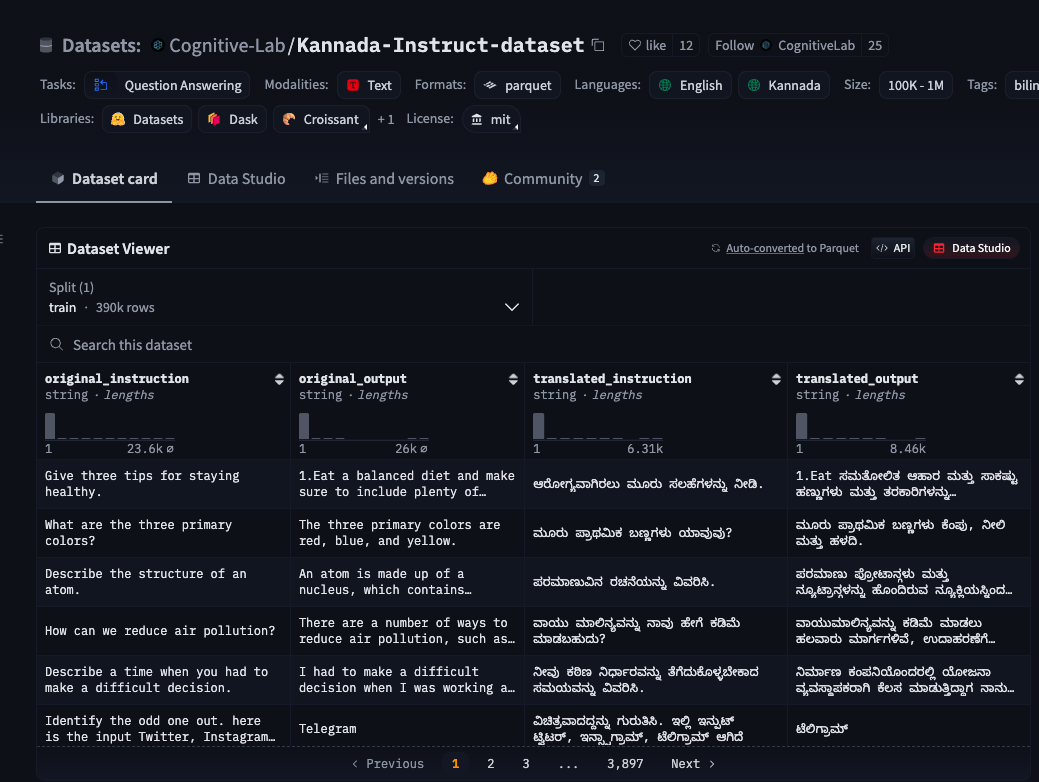

# Byte Pair Encoding

I've implemented the Byte Pair Encoding algorithm based on my understanding.

Both variants - merging at a byte level and at a character level.


The idea of BPE was originally proposed as a data compression algorithm, ([Gage 1994](http://www.pennelynn.com/Documents/CUJ/HTML/94HTML/19940045.HTM)), which was further adapted at the [Neural Machine Translation of Rare Words with Subword Units](https://arxiv.org/pdf/1508.07909). In the paper, the following  is seen

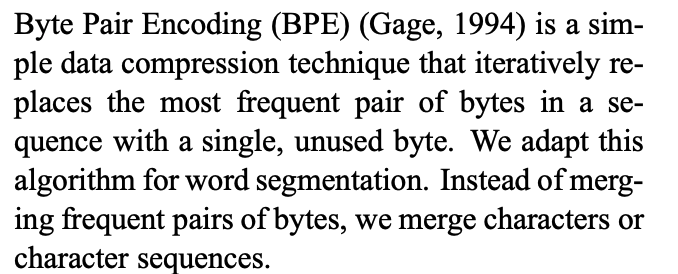

In [25]:
import regex as re, string
from collections import defaultdict

class BytePairEncoding:
  def __init__(self, corpus, desired_vocab_size, use_bytes=True): # merge at the byte level by default
    self.desired_vocab_size = desired_vocab_size
    self.corpus = corpus
    self.use_bytes = use_bytes
    self.vocab = self._generate_vocab()
    self.text = self._pre_process_byte_segmentation(corpus) if use_bytes else self._pre_process_word_segmentation(corpus)

    self.training_text = self.text[:]
    self.merges = dict()
    self._train_tokenizer()
    print("merges:", self.merges)
    print("vocab:", self.vocab)

  def _generate_vocab(self):
    if self.use_bytes:
      return {idx: bytes([idx]) for idx in range(256)}
    # for english, add all upper, lower case letters and digits
    all_chars = list(string.ascii_letters + string.punctuation + string.digits + " ")
    return {idx: all_chars[idx] for idx in range(len(all_chars))}

  def _pre_process_word_segmentation(self, corpus):
    # Using the GPT-4 regex pattern, reference - https://github.com/karpathy/minbpe/blob/1acefe89412b20245db5a22d2a02001e547dc602/minbpe/regex.py#L19
    word_split_pattern = re.compile(r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+""")

    # for english, add all upper, lower case letters and digits
    all_chars = list(string.ascii_letters + string.punctuation + string.digits + " ")
    return [[all_chars.index(char) for char in word] for word in re.findall(word_split_pattern, corpus)]

  def _pre_process_byte_segmentation(self, corpus):
    delimiter = "#" # consider # as the delimiter since spaces are to be retained
    corpus.replace(" ", " #")
    return [list(word.encode("utf-8")) for word in corpus.split(delimiter)]

  def _get_length(self, text):
    return sum([len(word) for word in text])

  def _train_tokenizer(self):
    # run the merge pair operation based on the desired vocabulary size
    merge_index = len(self.vocab)
    for index in range(len(self.vocab), self.desired_vocab_size):
      # get the most frequent pair
      pair = self._get_most_frequent_pair()
      if pair == []:
        break

      # track the merges
      self.merges[pair] = merge_index

      # add the representation to the vocabulary, will come handy while decoding
      self.vocab[merge_index] = self.vocab[pair[0]] + self.vocab[pair[1]]

      merge_index += 1

      # perform the merge
      self.training_text = self._merge_pair(pair, self.training_text)

  def _get_most_frequent_pair(self):
    # compute the most frequent word in the current state of the training text
    pair_counts = defaultdict(int)
    for word in self.training_text:
      for i in range(len(word) - 1):
        pair = (word[i], word[i + 1])
        pair_counts[pair] += 1
    # get the key with the maximum value, i.e here maximum occurrence frequency
    return [] if len(pair_counts) == 0 else max(pair_counts, key=pair_counts.get)

  def _merge_pair(self, pair, text):
    for word_idx, word in enumerate(text):
      word_with_merged_pairs = []
      char_idx = 0
      # merge pairs
      while char_idx < len(word):
        if char_idx < len(word) - 1 and word[char_idx] == pair[0] and word[char_idx + 1] == pair[1]:
            word_with_merged_pairs.append(self.merges[pair])
            char_idx += 2
            continue
        word_with_merged_pairs.append(word[char_idx])
        char_idx += 1
      text[word_idx] = word_with_merged_pairs
    return text

  def encode(self, text):
    text = self._pre_process_byte_segmentation(text) if self.use_bytes else self._pre_process_word_segmentation(text)
    print(f"---------------------------------------------")
    print("text before merging pairs:", text)
    # size is the number of bytes or number of characters
    print("size:", self._get_length(text))
    for merge_pair in self.merges:
      # merge pairs obtained while training the tokenizer
      text = self._merge_pair(merge_pair, text)

    print("text after merging pairs:", text)
    print("size:", self._get_length(text))
    return text

  def decode(self, text):
    decoded_text = []
    for word in text:
      word_decoded = []
      for char in word:
        word_decoded.append(self.vocab[char])

      # if bytes are used, combine it into a byte string and then decode using utf-8, reversal of the encoding operation
      if self.use_bytes:
        decoded_text.append((b"".join(word_decoded)).decode("utf-8"))
      else:
        decoded_text.append("".join(word_decoded))
    return "".join(decoded_text)



In [ ]:
desired_vocab_size = 450
corpus = " ".join(dataset["train"]["translated_output"][1000])
bpe = BytePairEncoding(corpus, desired_vocab_size)

In [ ]:
# verify if encoding and decoding is happening correctly
print(corpus == bpe.decode(bpe.encode(corpus)))

In [28]:
test = "ಕನ್ನಡ"
print(bpe.encode(test))

---------------------------------------------
text before merging pairs: [[224, 178, 149, 224, 178, 168, 224, 179, 141, 224, 178, 168, 224, 178, 161]]
size: 15
text after merging pairs: [[280, 149, 280, 168, 224, 179, 141, 280, 168, 280, 161]]
size: 11
[[280, 149, 280, 168, 224, 179, 141, 280, 168, 280, 161]]
